In [1]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import catboost as cb

COLOR_DICT = {
    "BLUE": "#2a5674",
    "RED": "#b13f64",
    "GOLD": "#e6b54a",
    "TEAL": "#4a9b8f",
    "CORAL": "#f47c65",
    "PURPLE": "#6a4a99",
    "ORANGE": "#f28c28",
    "GREEN": "#4a9b4a",
    "PINK": "#d47ca6"
}

colors = [COLOR_DICT[color] for color in ["RED", "BLUE", "GOLD", "TEAL", "CORAL", "PURPLE", "ORANGE", "GREEN", "PINK"]]

In [2]:
def flip_batter_cols(dataFull):
    for flip_col in ["release_pos_x","plate_x","pfx_x"]:
        dataFull[f"{flip_col}_bat_flip"]=np.where(dataFull["stand"]=="L",dataFull[flip_col].mul(-1),dataFull[flip_col])

    return dataFull

def add_event_cols(dataFull):
    dataFull["bip_event"] = np.where(
        dataFull["description"] != "hit_into_play",
        np.nan,
        np.where(
            dataFull["events"].isin(["single","double","triple","home_run"]),
            dataFull["events"],
            "bip_out"
        )
    )

    descriptions_init = list(dataFull["description"].unique())
    swing_descriptions = [desc for desc in descriptions_init if "foul" in desc or "bunt" in desc or "swing" in desc or "hit_into" in desc]
    strike_descriptions = [desc for desc in descriptions_init if "foul" in desc or "strike" in desc or "missed_bunt" in desc]
    ball_descriptions = ["ball","blocked_ball"]
    whiff_descrptions = [desc for desc in descriptions_init if "swinging_strike" in desc or "foul_tip" in desc]
    
    dataFull["is_swing"] = (dataFull["description"].isin(swing_descriptions)).astype(int)
    dataFull["is_whiff"] = (dataFull["description"].isin(whiff_descrptions)).astype(int)
    dataFull["is_in_play"] = (dataFull["description"]=="hit_into_play").astype(int)

    dataFull["is_take"] = 1-(dataFull["is_swing"])
    dataFull["is_foul"] = dataFull["is_swing"].astype(int) - dataFull["is_whiff"] - dataFull["is_in_play"]
    dataFull["is_out"] = (dataFull["bip_event"]=="bip_out").astype(int)
     
    dataFull["is_strike"] = dataFull["description"].isin(strike_descriptions).astype(int)
    dataFull["is_called_strike"] = np.where(dataFull["is_take"]==0,0,dataFull["is_strike"])
    dataFull["is_ball"] = dataFull["description"].isin(ball_descriptions).astype(int)
    dataFull["is_called_ball"] = dataFull["description"].isin(ball_descriptions).astype(int)

    dataFull["post_strikes"] = dataFull["strikes"].shift(-1).fillna(0)
    dataFull["post_balls"] = dataFull["balls"].shift(-1).fillna(0)
    dataFull.loc[(dataFull["strikes"]==2)&(dataFull["post_strikes"]>0)&(dataFull["is_foul"]==1),"is_strike"]=0

    dataFull["take_event"] = np.where(
        dataFull["description"] == "called_strike",
        "called_strike",
        np.where(
            dataFull["description"]=="ball",
            "called_ball",
            np.where(dataFull["description"]=="hit_by_pitch","hit_by_pitch",np.nan)
        )
    )
    
    dataFull["swing_event"] = np.where(
        dataFull["is_swing"]!=1,
        np.nan,
        np.where(
            dataFull["description"].str.contains("foul"),
            "foul",
            np.where(
                dataFull["description"].str.contains("swinging_strike"),
                "whiff",
                np.where(
                    dataFull["description"].str.contains("missed_bunt"),
                    "whiff",
                    "hit_into_play"
                )
            )
        )
    )
    
    dataFull["swing_or_take"] = np.where(dataFull["is_swing"]==1,"swing","take")

    return dataFull

def add_fa_metrics(dataFull):
    dataFull["thrown_split"] = (
        dataFull
        [["pitcher","stand","pitch_type","release_speed"]]
        .groupby(["pitcher","stand","pitch_type"])
        .transform("count")
    )
    
    dataFull["fa_thrown_split"] = np.where(
        dataFull["pitch_type"].isin(["FF","SI","FC"]),
        dataFull["thrown_split"],
        np.nan
    )
    
    dataFull["max_fa_thrown"] = dataFull[["pitcher","stand","fa_thrown_split"]].groupby(["pitcher","stand"]).transform("max")
    
    for col in ["release_speed","pfx_x","pfx_z"]:
        dataFull[f"{col}_pitch_type_mean"] = (
            dataFull
            [["pitcher","stand","pitch_type",col]]
            .groupby(["pitcher","stand","pitch_type"])
            .transform("mean")
        )
        
        dataFull[f"fa_{col}_init"] = np.where(
            dataFull["pitch_type"].isin(["FF","SI","FC"]),
            np.where(
                dataFull["fa_thrown_split"] == dataFull["max_fa_thrown"],
                dataFull[f"{col}_pitch_type_mean"],
                np.nan
            ),
            np.nan
        )
    
        dataFull[f"fa_{col}"] = dataFull[["pitcher","stand",f"fa_{col}_init"]].groupby(["pitcher","stand"]).transform("mean")
    
        dataFull[f"{col}_diff"] = dataFull[col] - dataFull[f"fa_{col}"]

    drop_cols = ["thrown_split","fa_thrown_split","max_fa_thrown"]
    drop_cols += [col for col in dataFull.columns if col.startswith("fa_") and col.endswith("_init")]
    drop_cols += [col for col in dataFull.columns if col.endswith("_pitch_type_mean")]
    
    return dataFull.drop(drop_cols, axis = "columns")

def add_rv_cols(dataFull):
    
    original_cols = list(dataFull.columns)
    
    outcomes = {"single": "is_single", "double": "is_double", "triple": "is_triple", "home_run": "is_home_run"}
    for outcome, column in outcomes.items():
        dataFull[column] = (dataFull["bip_event"]==outcome).astype(int)
        
    dataFull["is_hit_by_pitch"] = (dataFull["description"].str.lower().str.contains("hit_by_pitch")).astype(int)
        
    rv_events = [
        "is_strike","is_ball",
        "is_called_strike","is_called_ball",
        "is_foul",
        "is_single","is_double","is_triple","is_home_run","is_out",
        "is_hit_by_pitch"
    ]
    rv_cols = [f"rv_{event.split('is_')[1]}" for event in rv_events]
    
    for event, rv_col in zip(rv_events, rv_cols):
        if rv_col in dataFull.columns:
            dataFull = dataFull.drop(columns=[col for col in dataFull.columns if rv_col in col])
        group_cols = ["balls","strikes","game_year"]
        dataFull = dataFull.merge(
            dataFull
            .loc[(dataFull[event]==1)]
            [["delta_run_exp"] + group_cols]
            .groupby(group_cols)
            .mean()
            .rename(columns = {"delta_run_exp":rv_col})
            .reset_index(),
            on = group_cols,
            how = "left",
        )

    return dataFull

def add_spray_angle(dataFull):
    dataFull["spray_angle"]= (
        180/np.pi* 
        np.arctan2(
            (dataFull["hc_x"]-125.42),(-1*dataFull["hc_y"]+198.27)
        )
    )
    
    dataFull["spray_angle_norm"] = np.where(
        dataFull["stand"] == "R",
        dataFull["spray_angle"]*-1,
        dataFull["spray_angle"]
    )

    return dataFull

def add_pred_wraa_mcova(
    dataFull,
    float_vars,
    cat_vars,
    target_var,
    pred_name,
    met_name,
    save_models_bool,
    load_models_bool,
    model_path,
    model_name,
):
    
    import catboost as cb
    
    input_vars = float_vars + cat_vars
    
    params = dict(
        verbose=False,
        loss_function="MultiClassOneVsAll", 
        eval_metric="AUC",
        cat_features=cat_vars,
    )
    
    model_data = dataFull[[target_var] + input_vars].copy().dropna()
    predict_data = dataFull[input_vars].copy().dropna()
    predict_indeces = predict_data.index
    
    model_woba = cb.CatBoostClassifier(**params)

    if not load_models_bool:
        model_woba.fit(model_data[input_vars], model_data[target_var])
    else:
        model_woba.load_model(model_path+target_var+"_"+model_name+".cbm",format="cbm")
    if save_models_bool:
        model_woba.save_model(model_path+target_var+"_"+model_name+".cbm",format="cbm")
    
    woba_predictions = model_woba.predict_proba(predict_data)
    
    dataFull[met_name] = np.nan
    dataFull.loc[predict_indeces,met_name] = 0.0

    final_classes = []
    for i, bip_result in enumerate(list(model_woba.classes_)):
        final_classes += [f"{bip_result}{pred_name}"]
        dataFull[f"{bip_result}{pred_name}"] = np.nan
        dataFull.loc[predict_indeces,f"{bip_result}{pred_name}"] = woba_predictions[:,i]

    dataFull[final_classes] = dataFull[final_classes].div(dataFull[final_classes].sum(axis=1), axis=0)

    for i, bip_result in enumerate(list(model_woba.classes_)):
        _woba_value = dataFull.loc[(dataFull[target_var]==bip_result),"delta_run_exp"].mean()
        dataFull.loc[predict_indeces,met_name] += (woba_predictions[:,i] * _woba_value)

    return dataFull, model_woba

def downcast_dtypes(df):
    float_columns = df.select_dtypes(include=["float64"]).columns
    int_columns = df.select_dtypes(include=["int64"]).columns
    
    df[float_columns] = df[float_columns].apply(pd.to_numeric, downcast="float")
    df[int_columns] = df[int_columns].apply(pd.to_numeric, downcast="integer")
    
    return df

In [3]:
def pitch_model(
    dataFull,
    train_data,
    save_models_bool,
    load_models_bool,
    model_path,
    model_cols,
    cat_cols,
    model_name,
):
    
    train_cols = ["xwraacon","swing_event","take_event","swing_or_take"]
    linear_predictions = ["xwraacon"]

    predict_data = dataFull.dropna(subset=model_cols)
    predict_indeces = predict_data.index
    
    for train_col in train_cols:

        if not load_models_bool:
            _df_train = train_data[model_cols + train_cols].copy()
            
        linear_cb = cb.CatBoostRegressor(
            loss_function = "RMSE",
            verbose = False,
            random_seed = 3024,
            cat_features = cat_cols,
        )
        
        mc_cb = cb.CatBoostClassifier(
            loss_function="MultiClass",
            verbose = False,
            random_seed = 3024,
            cat_features = cat_cols,
        )
        
        if train_col in linear_predictions:
            model_used = linear_cb
        else:
            model_used = mc_cb
            
        if load_models_bool:
            model_used.load_model(model_path +train_col+"_"+model_name + ".cbm", format="cbm")
        else:
            model_used.fit(
                _df_train.loc[_df_train[train_col]!="nan"].dropna(subset = model_cols + [train_col])[model_cols],
                _df_train.loc[_df_train[train_col]!="nan"].dropna(subset = model_cols + [train_col])[train_col]
            )
            if save_models_bool:
                model_used.save_model(model_path + train_col+"_"+model_name + ".cbm", format="cbm")

        if train_col in linear_predictions:
            Predicted = model_used.predict(predict_data[model_cols])
            dataFull[train_col + "_pred_" + model_name]=np.nan
            dataFull.loc[predict_indeces,train_col + "_pred_" + model_name] = Predicted.astype(float)
        else:
            Predicted = model_used.predict_proba(predict_data[model_cols])
            for i, class_i in enumerate(model_used.classes_):
                dataFull[class_i + "_pred_" + model_name]=np.nan
                dataFull.loc[predict_indeces,class_i + "_pred_" + model_name] = Predicted[:,i]
        del Predicted
                
        if not load_models_bool:
            del _df_train
    
    dataFull["xrv_if_take_"+model_name] = (
        dataFull["called_ball_pred_"+model_name] * dataFull["rv_called_ball"] +
        dataFull["called_strike_pred_"+model_name] * dataFull["rv_called_strike"] +
        dataFull["hit_by_pitch_pred_"+model_name] * dataFull["rv_hit_by_pitch"]
    )
    
    dataFull["xrv_if_swing_"+model_name] = (
        dataFull["hit_into_play_pred_"+model_name] * dataFull["xwraacon_pred_"+model_name] +
        dataFull["foul_pred_"+model_name] * dataFull["rv_foul"] +
        dataFull["whiff_pred_"+model_name] * dataFull["rv_strike"]
    )
    
    dataFull["xrv_final_"+model_name] = (
        dataFull["swing_pred_"+model_name] * dataFull["xrv_if_swing_"+model_name] +
        dataFull["take_pred_"+model_name] * dataFull["xrv_if_take_"+model_name]
    )

    dataFull["swinging_strike_pred_"+model_name] = (
        dataFull["swing_pred_"+model_name]*dataFull["whiff_pred_"+model_name]
    )

    dataFull["expected_damage_"+model_name] = (
        dataFull["swing_pred_"+model_name]*dataFull["hit_into_play_pred_"+model_name] * dataFull["xwraacon_pred_"+model_name]
    )

    if "is_swing" in dataFull.columns:
        dataFull[f"zone_awareness_{model_name}"] = (dataFull["is_swing"].mul(2).sub(1)) * (dataFull[f"called_strike_pred_{model_name}"].astype(float).sub(0.5))

    return dataFull

In [4]:
df_list = []
drop_pitches = ["EP","PO","SC","FA"]

for input_year in [2023,2024]:
    folder_name = "./statcast_pickles//"
    pickle_name = f"statcast_{input_year}_raw.pkl"
    _dataFull = downcast_dtypes(
        pd.read_pickle(folder_name + pickle_name)
        .dropna(subset = ["pfx_x","pfx_z","release_speed","pitch_type","release_extension","ax"])
        .query("""game_type=='R'""")
    )
    _dataFull = _dataFull.loc[(~(_dataFull["pitch_type"].isin(drop_pitches)))]
    df_list.append(_dataFull)

dataFull = pd.concat(df_list).reset_index(drop = True)

try:
    del df_list, _dataFull
except:
    del df_list

In [5]:
dataFull = flip_batter_cols(dataFull)
dataFull = add_event_cols(dataFull)
dataFull = add_fa_metrics(dataFull)
dataFull = add_rv_cols(dataFull)
dataFull = add_spray_angle(dataFull)
dataFull = downcast_dtypes(dataFull)

In [6]:
dataFull, model_woba_3d_ova = add_pred_wraa_mcova(
    dataFull,
    float_vars = ["launch_speed","launch_angle","spray_angle_norm"],
    cat_vars = [],
    target_var = "bip_event",
    pred_name = "_pred_3d_wraa",
    met_name = "xwraacon",
    save_models_bool=True,
    load_models_bool=False,
    model_path=r".\stuff_models_bat_update\\",
    model_name="xwraacon_3d",
)

In [7]:
stance_data = (
    pd
    .read_csv("batter_stance_data.csv")
    .rename(columns={
        "id":"batter",
        "name":"batter_name",
        "side":"stand",
        "year":"game_year",
    })
)

dataFull["month"] = pd.to_datetime(dataFull["game_date"]).dt.month
dataFull["is_2_strikes"] = (dataFull["strikes"]>=2).astype(int)

merge_cols = ["batter","stand","game_year","month","is_2_strikes"]
new_cols = [col for col in stance_data.columns if col not in merge_cols]
existing_cols = [col for col in dataFull.columns if col in new_cols]

dataFull = dataFull.drop(columns=existing_cols).merge(stance_data,on=merge_cols,how="left")

for col in ["bat_speed","swing_length","launch_speed","launch_angle"]:
    dataFull[col] = dataFull[col].replace("--",np.nan).astype(float).values

dataFull["10pctile_bat_speed"] = (
    dataFull[["batter","game_year","stand","bat_speed"]]
    .groupby(["batter","game_year","stand"])
    ["bat_speed"].transform(lambda x: np.nanquantile(x, q=0.1))
)

dataFull["competitive_bat_speed"] = np.where(
    (dataFull["bat_speed"]>dataFull["10pctile_bat_speed"])|((dataFull["bat_speed"]>=60)&(dataFull["launch_speed"]>=90)),
    dataFull["bat_speed"],
    np.nan
)

for col in ["bat_speed","swing_length"]:
    dataFull[f"{col}_orig"] = dataFull[col].values
    dataFull[col] = np.where(
        (dataFull["bat_speed"]>dataFull["10pctile_bat_speed"])|((dataFull["bat_speed"]>=60)&(dataFull["launch_speed"]>=90)),
        dataFull[col],
        np.nan
    )
    dataFull[f"average_{col}"] = dataFull[["batter","game_year","stand",col]].groupby(["batter","game_year","stand"]).transform(np.nanmean)

model_cols = [
    "release_speed",
    "pfx_x_bat_flip","pfx_z",
    "release_extension","release_pos_x_bat_flip","release_pos_z",
    "fa_release_speed","pfx_x_diff","pfx_z_diff",
    "plate_x_bat_flip","plate_z",  
    "stand","balls","strikes",
] + [
    "avg_batter_y_position",
    "avg_batter_x_position",
    "avg_foot_sep",
    "avg_stance_angle",
    "avg_intercept_y_vs_batter",
    "avg_intercept_y_vs_plate",
] + [
    "average_bat_speed",
    "average_swing_length",
]

dataFull = dataFull.dropna(subset=model_cols)

In [8]:
from sklearn.model_selection import train_test_split
train_data, test_data = train_test_split(dataFull, test_size=0.5, random_state=3024)
train_ind = train_data.index
test_ind = test_data.index

In [9]:
model_cols = [
    "release_speed",
    "pfx_x_bat_flip","pfx_z",
    "release_extension","release_pos_x_bat_flip","release_pos_z",
    "fa_release_speed","pfx_x_diff","pfx_z_diff",
    "plate_x_bat_flip","plate_z",  
    "stand","balls","strikes",
]

cat_cols = ["stand","balls","strikes"]

dataFull = pitch_model(
    dataFull=dataFull,
    train_data=train_data,
    save_models_bool=True,
    load_models_bool=False,
    model_path=r".\stuff_models_bat_update\\",
    model_cols=model_cols,
    cat_cols=cat_cols,
    model_name="pitching_base",
)

In [10]:
model_cols = [
    "release_speed",
    "pfx_x_bat_flip","pfx_z",
    "release_extension","release_pos_x_bat_flip","release_pos_z",
    "fa_release_speed","pfx_x_diff","pfx_z_diff",
    "plate_x_bat_flip","plate_z",  
    "stand","balls","strikes",
] + [
    "avg_batter_y_position",
    "avg_batter_x_position",
    "avg_foot_sep",
    "avg_stance_angle",
    "avg_intercept_y_vs_batter",
    "avg_intercept_y_vs_plate"
]

cat_cols = ["stand","balls","strikes"]

dataFull = pitch_model(
    dataFull=dataFull,
    train_data=train_data,
    save_models_bool=True,
    load_models_bool=False,
    model_path=r".\stuff_models_bat_update\\",
    model_cols=model_cols,
    cat_cols=cat_cols,
    model_name="pitching_stance",
)

In [11]:
model_cols = [
    "release_speed",
    "pfx_x_bat_flip","pfx_z",
    "release_extension","release_pos_x_bat_flip","release_pos_z",
    "fa_release_speed","pfx_x_diff","pfx_z_diff",
    "plate_x_bat_flip","plate_z",  
    "stand","balls","strikes",
] + ["average_bat_speed","average_swing_length"]

cat_cols = ["stand","balls","strikes"]

dataFull = pitch_model(
    dataFull=dataFull,
    train_data=train_data,
    save_models_bool=True,
    load_models_bool=False,
    model_path=r".\stuff_models_bat_update\\",
    model_cols=model_cols,
    cat_cols=cat_cols,
    model_name="pitching_swing",
)

In [13]:
model_cols = [
    "release_speed",
    "pfx_x_bat_flip","pfx_z",
    "release_extension","release_pos_x_bat_flip","release_pos_z",
    "fa_release_speed","pfx_x_diff","pfx_z_diff",
    "plate_x_bat_flip","plate_z",  
    "stand","balls","strikes",
] + [
    "avg_batter_y_position",
    "avg_batter_x_position",
    "avg_foot_sep",
    "avg_stance_angle",
    "avg_intercept_y_vs_batter",
    "avg_intercept_y_vs_plate"
] + [
    "average_bat_speed",
    "average_swing_length"
]

cat_cols = ["stand","balls","strikes"]

dataFull = pitch_model(
    dataFull=dataFull,
    train_data=train_data,
    save_models_bool=True,
    load_models_bool=False,
    model_path=r".\stuff_models_bat_update\\",
    model_cols=model_cols,
    cat_cols=cat_cols,
    model_name="pitching_stance_and_swing",
)

In [14]:
from great_tables import *

(
    GT(
        dataFull
        .loc[test_ind,[
            "xrv_final_pitching_base",
            "xrv_final_pitching_stance",
            "xrv_final_pitching_swing",
            "xrv_final_pitching_stance_and_swing",
            "delta_run_exp"
        ]]
        .corr()
        .round(3)
        .rename(
            columns={"delta_run_exp":"Correlation to Observed Run Value"},
            index={
                "xrv_final_pitching_base":"Baseline Pitch Model",
                "xrv_final_pitching_stance":"Pitch Model with Batter's Setup Data",
                "xrv_final_pitching_swing":"Pitch Model with Batter's Average Bat Speed and Swing Length",
                "xrv_final_pitching_stance_and_swing":"Pitch Model with Bat Speed, Swing Length, and Setup",
            }
        )
        .iloc[:-1,-1].reset_index().rename(columns={"index":"Model Description"})
    )
    .data_color(
        columns=["Correlation to Observed Run Value"],
        palette="Reds",
    )
    .opt_stylize(style=5)
    .tab_header(
        title="Pitch Model Out of Sample Correlations",
    )
)

GT(_tbl_data=                                   Model Description  \
0                               Baseline Pitch Model   
1               Pitch Model with Batter's Setup Data   
2  Pitch Model with Batter's Average Bat Speed an...   
3  Pitch Model with Bat Speed, Swing Length, and ...   

   Correlation to Observed Run Value  
0                              0.172  
1                              0.174  
2                              0.175  
3                              0.177  , _body=<great_tables._gt_data.Body object at 0x000001A1801CF690>, _boxhead=Boxhead([ColInfo(var='Model Description', type=<ColInfoTypeEnum.default: 1>, column_label='Model Description', column_align='left', column_width=None), ColInfo(var='Correlation to Observed Run Value', type=<ColInfoTypeEnum.default: 1>, column_label='Correlation to Observed Run Value', column_align='right', column_width=None)]), _stub=<great_tables._gt_data.Stub object at 0x000001A19A314250>, _spanners=Spanners([]), _heading=Heading(title='Pitch Model Out of Sample Correlations', subtitle=None, preheader=None), _stubhead=None, _source_notes=[], _footnotes=[], _styles=[StyleInfo(locname=LocBody(columns='Correlation to Observed Run Value', rows=[0], mask=None), grpname=None, colname='Correlation to Observed Run Value', rownum=0, colnum=None, styles=[CellStyleText(color='#000000', font=None, size=None, align=None, v_align=None, style=None, weight=None, stretch=None, decorate=None, transform=None, whitespace=None), CellStyleFill(color='#fff5f0')]), StyleInfo(locname=LocBody(columns='Correlation to Observed Run Value', rows=[1], mask=None), grpname=None, colname='Correlation to Observed Run Value', rownum=1, colnum=None, styles=[CellStyleText(color='#000000', font=None, size=None, align=None, v_align=None, style=None, weight=None, stretch=None, decorate=None, transform=None, whitespace=None), CellStyleFill(color='#fc8a6a')]), StyleInfo(locname=LocBody(columns='Correlation to Observed Run Value', rows=[2], mask=None), grpname=None, colname='Correlation to Observed Run Value', rownum=2, colnum=None, styles=[CellStyleText(color='#000000', font=None, size=None, align=None, v_align=None, style=None, weight=None, stretch=None, decorate=None, transform=None, whitespace=None), CellStyleFill(color='#f14432')]), StyleInfo(locname=LocBody(columns='Correlation to Observed Run Value', rows=[3], mask=None), grpname=None, colname='Correlation to Observed Run Value', rownum=3, colnum=None, styles=[CellStyleText(color='#FFFFFF', font=None, size=None, align=None, v_align=None, style=None, weight=None, stretch=None, decorate=None, transform=None, whitespace=None), CellStyleFill(color='#67000d')])], _locale=<great_tables._gt_data.Locale object at 0x000001A1F862AA90>, _formats=[], _substitutions=[], _options=Options(table_id=OptionsInfo(scss=False, category='table', type='value', value=None), table_caption=OptionsInfo(scss=False, category='table', type='value', value=None), table_width=OptionsInfo(scss=True, category='table', type='px', value='auto'), table_layout=OptionsInfo(scss=True, category='table', type='value', value='fixed'), table_margin_left=OptionsInfo(scss=True, category='table', type='px', value='auto'), table_margin_right=OptionsInfo(scss=True, category='table', type='px', value='auto'), table_background_color=OptionsInfo(scss=True, category='table', type='value', value='#FFFFFF'), table_additional_css=OptionsInfo(scss=False, category='table', type='values', value=[]), table_font_names=OptionsInfo(scss=False, category='table', type='values', value=['-apple-system', 'BlinkMacSystemFont', 'Segoe UI', 'Roboto', 'Oxygen', 'Ubuntu', 'Cantarell', 'Helvetica Neue', 'Fira Sans', 'Droid Sans', 'Arial', 'sans-serif']), table_font_size=OptionsInfo(scss=True, category='table', type='px', value='16px'), table_font_weight=OptionsInfo(scss=True, category='table', type='value', value='normal'), table_font_style=OptionsInfo(scss=True, category='table', type='value', value='normal'), table_font_color=Opt

In [15]:
def create_plate_grid(
    input_data,
    model_cols,
    count_vals,
    stand_vals
):
    import polars as pl
    import itertools
    
    granularity_z = 0.1  # units of feet
    granularity_x = 0.1  # units of feet
    plate_z = np.arange(1, 4.5, granularity_z)
    plate_x = np.arange(-2.0, 2.0, granularity_x)
    combinations_full = list(itertools.product(plate_z, plate_x, count_vals[0], count_vals[1], stand_vals))

    output_data = pl.DataFrame(combinations_full, schema=["plate_z","plate_x","balls","strikes","stand"])

    for flip_col in ["plate_x"]:
        output_data = output_data.with_columns(
            pl.when(pl.col("stand")=="L").then(pl.col(flip_col)*-1).otherwise(pl.col(flip_col)).alias(f"{flip_col}_bat_flip"),
        )
    for col in model_cols:
        if col not in ["plate_z","plate_x","balls","strikes","stand","plate_x_bat_flip"]:
            output_data = output_data.with_columns(
                pl.lit(input_data[col].mean()).alias(col)
            )

    return output_data.to_pandas()

In [16]:
def plate_heat_map(
    input_data,
    feature,
    limits,
    ax,
    color_map,
    perspective,
    batter_hand,
):

    vmin_in = np.min(limits)
    vmax_in = np.max(limits)

    pivot_table = pd.pivot_table(
        pd.concat([input_data[["plate_x","plate_z"]],input_data[feature]], axis=1), 
        values=feature, 
        index=["plate_z"], 
        columns=["plate_x"]
    )
    
    Z = np.clip(pivot_table.values,vmin_in,vmax_in)
    
    n_cont = 100

    if perspective == "pitcher":
        if batter_hand=="L":
            cp = ax.contourf(
                np.linspace(input_data["plate_x"].min(), input_data["plate_x"].max(), num=np.shape(Z)[1]),
                np.linspace(input_data["plate_z"].min(), input_data["plate_z"].max(), num=np.shape(Z)[0]), 
                Z, 
                n_cont, 
                cmap=color_map, 
                extend = "min",
            )
        else:
            cp = ax.contourf(
                np.linspace(input_data["plate_x"].max(), input_data["plate_x"].min(), num=np.shape(Z)[1]),
                np.linspace(input_data["plate_z"].min(), input_data["plate_z"].max(), num=np.shape(Z)[0]), 
                Z, 
                n_cont, 
                cmap=color_map, 
                extend = "min",
            )
            
    else:
        if batter_hand=="L":
            cp = ax.contourf(
                np.linspace(input_data["plate_x"].max(), input_data["plate_x"].min(), num=np.shape(Z)[1]),
                np.linspace(input_data["plate_z"].min(), input_data["plate_z"].max(), num=np.shape(Z)[0]), 
                Z, 
                n_cont, 
                cmap=color_map, 
                extend = "min",
            )
        else:  
            cp = ax.contourf(
                np.linspace(input_data["plate_x"].min(), input_data["plate_x"].max(), num=np.shape(Z)[1]),
                np.linspace(input_data["plate_z"].min(), input_data["plate_z"].max(), num=np.shape(Z)[0]), 
                Z, 
                n_cont, 
                cmap=color_map, 
                extend = "min",
            )
        

    cp.set_clim([vmin_in,vmax_in])

    for k in [0,1,2]:
        for n in [0,1,2]:
            ax.add_patch(
                plt.Rectangle(
                    (-0.85+(2*0.85/3)*k,1.6+((3.5-1.6)/3)*n),(2*0.85/3),(3.5-1.6)/3,
                    facecolor = "none", 
                    edgecolor = "black", 
                    linewidth = 0.5, 
                    linestyle = "dotted",
                )
            )
    
    ax.add_patch(
        plt.Rectangle(
            (-0.85,1.6),0.85*2,1.9,
            facecolor = "none", 
            edgecolor = "black", 
            linewidth = 1.5, 
            linestyle = "solid",
        )
    )

    ax.spines[["top","right","bottom","left"]].set_visible(False)

    ax.set(
        xlabel="",
        ylabel="",
        xticks=[],
        yticks=[],
    )

    ax.set_aspect("equal", adjustable="box")
    
    return ax

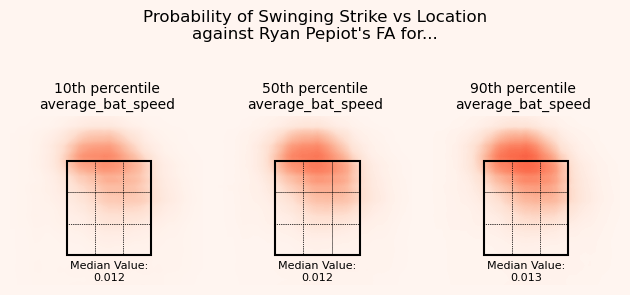

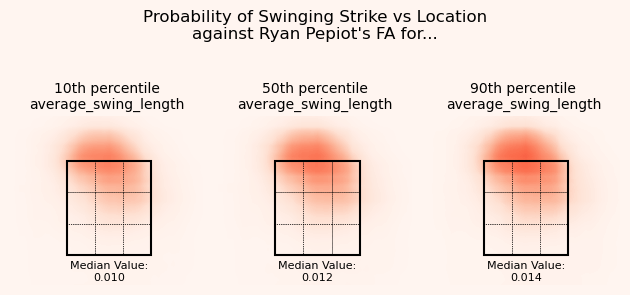

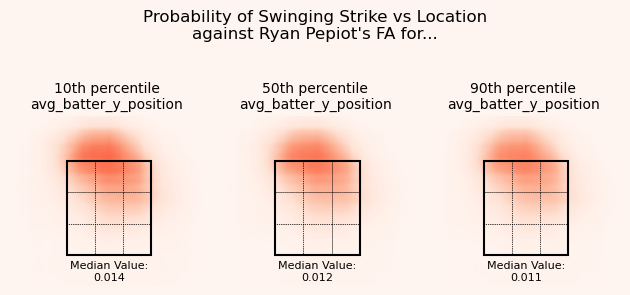

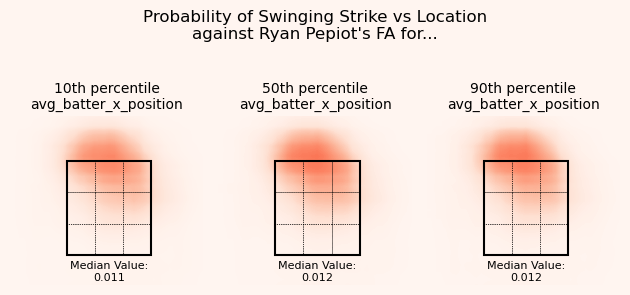

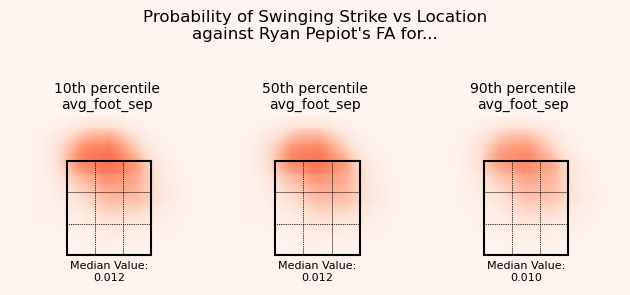

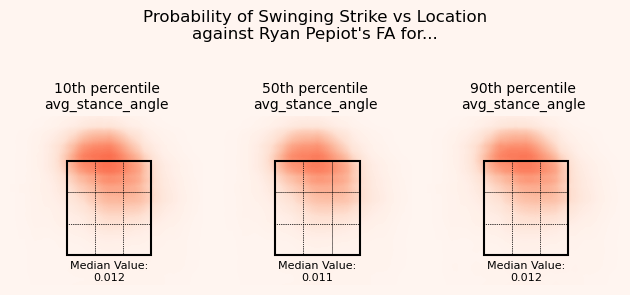

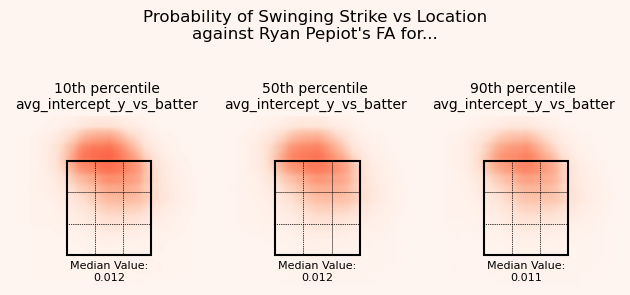

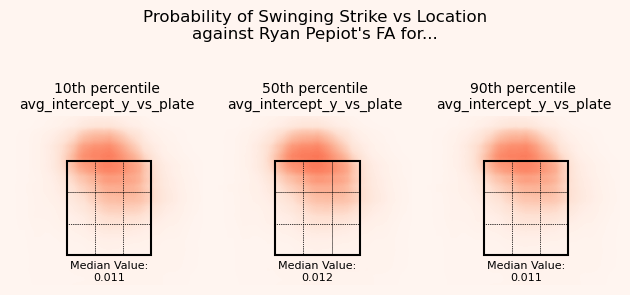

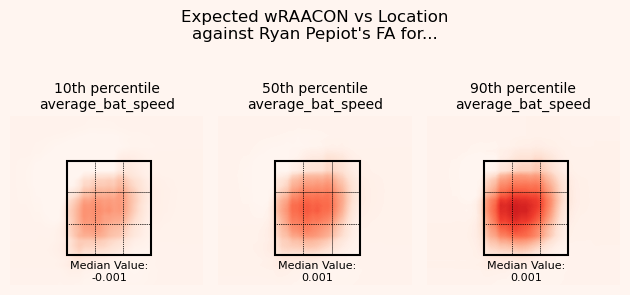

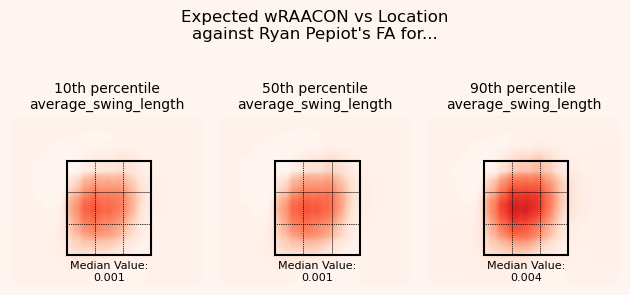

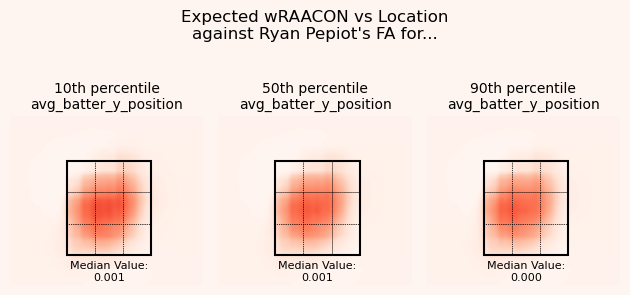

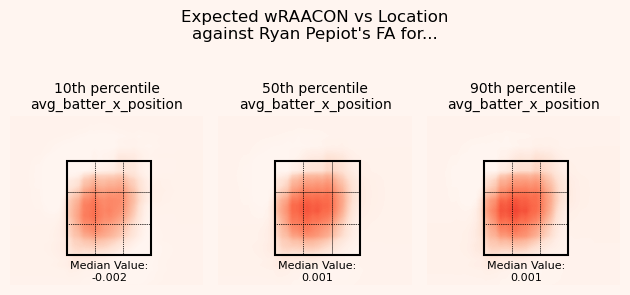

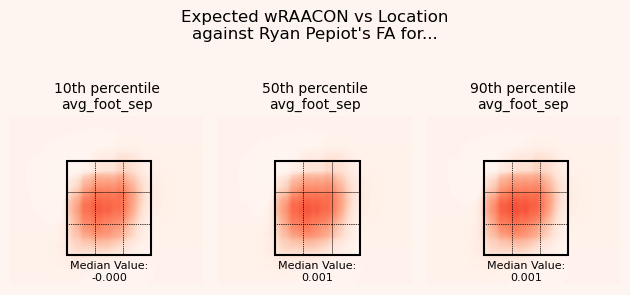

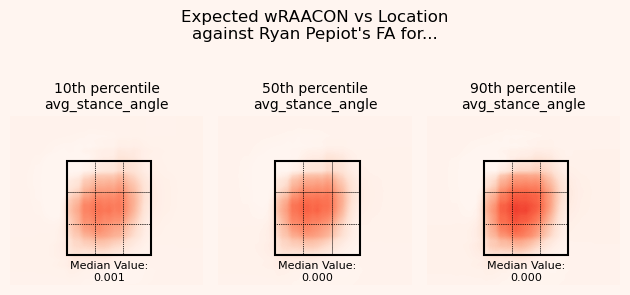

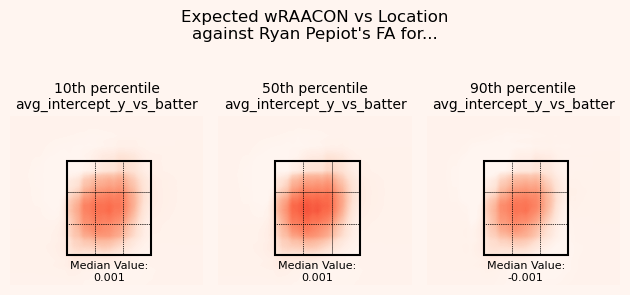

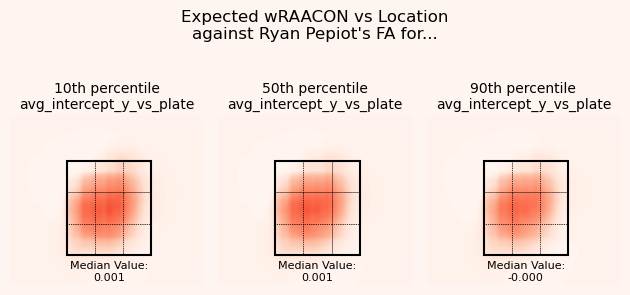

In [17]:
model_name="pitching_stance_and_swing"
pitch_type="FF"
pitcher_name="Ryan Pepiot"
season=2024
count_vals=[
    [0],
    [0]
]
stand_vals=["R"]
p_throws="R"
save_plot=False

name_parts = pitcher_name.split(" ")
reversed_name = ", ".join([name_parts[-1], name_parts[0]])

pitch_type_str = "FA" if pitch_type=="FF" else pitch_type

model_cols_test = [
    "release_speed",
    "pfx_x_bat_flip","pfx_z",
    "release_extension","release_pos_x_bat_flip","release_pos_z",
    "fa_release_speed","pfx_x_diff","pfx_z_diff",
    "plate_x_bat_flip","plate_z",  
    "stand","balls","strikes",
] + [
    "avg_batter_y_position",
    "avg_batter_x_position",
    "avg_foot_sep",
    "avg_stance_angle",
    "avg_intercept_y_vs_batter",
    "avg_intercept_y_vs_plate"
] + [
    "average_bat_speed",
    "average_swing_length"
]

if len(pitcher_name)==0:
    input_data=dataFull.loc[(dataFull["pitch_type"]==pitch_type)&(dataFull["game_year"]==season)&(dataFull["p_throws"]==p_throws)]
else:
    input_data=dataFull.loc[(dataFull["pitch_type"]==pitch_type)&(dataFull["game_year"]==season)&(dataFull["player_name"]==reversed_name)]

p_throws=input_data["p_throws"].mode()[0]

grid_data_init = create_plate_grid(
    input_data=input_data,
    model_cols=model_cols_test,
    count_vals=count_vals,
    stand_vals=stand_vals,
)

grid_data_init = grid_data_init.merge(
    dataFull[[col for col in dataFull.columns if col.startswith("rv_")]+["balls","strikes","stand"]]
    .groupby(["balls","strikes","stand"])
    .mean()
    .reset_index(),
    on=["balls","strikes","stand"],
    how="left"
)


test_var_dictionary = {
    # "swing_pred":{
    #     "title":"Probability of Swing",
    #     "color_map":"Reds",
    #     "limits":[0,1],
    # },
    # "whiff_pred":{
    #     "title":"Probability of Whiff if Swing",
    #     "color_map":"Reds",
    #     "limits":[0,1],
    # },
    "swinging_strike_pred":{
        "title":"Probability of Swinging Strike",
        "color_map":"Reds",
        "limits":[0,0.6],
    },
    "expected_damage":{
        "title":"Expected wRAACON",
        "color_map":"Reds",
        "limits":[-0.001,0.05],
    },
    # "called_strike_pred":{
    #     "title":"Probability of Called Strike if Taken",
    #     "color_map":"Reds",
    #     "limits":[0,1],
    # },
    # "xwraacon_pred":{
    #     "title":"Expected wRAACON if in Play",
    #     "color_map":"Reds",
    #     "limits":[-0.1,0.1],
    # },
}

for test_var in test_var_dictionary.keys():
    
    for mod_var in [
        "average_bat_speed",
        "average_swing_length",
        "avg_batter_y_position",
        "avg_batter_x_position",
        "avg_foot_sep",
        "avg_stance_angle",
        "avg_intercept_y_vs_batter",
        "avg_intercept_y_vs_plate",
    ]:
        feature=f"{test_var}_{model_name}"
        fig, axs=plt.subplots(1,3,facecolor="#FFF5F0",)
        for i,quantile in enumerate([0.10,0.5,0.90]):
            ax=axs[i]
            grid_data = grid_data_init.copy()
            grid_data[mod_var] = input_data[mod_var].quantile(quantile)
            
            grid_data = pitch_model(
                dataFull=grid_data,
                train_data=[],
                save_models_bool=False,
                load_models_bool=True,
                model_path=r".\stuff_models_bat_update\\",
                model_cols=model_cols_test,
                cat_cols=cat_cols,
                model_name=model_name,
            )
    
            ax=plate_heat_map(
                input_data=grid_data,
                feature=feature,
                limits=test_var_dictionary[test_var]["limits"],
                ax=ax,
                color_map=test_var_dictionary[test_var]["color_map"],
                perspective="catcher",
                batter_hand=stand_vals[0],
            )
        
            ax.set_title(
                f"{quantile*100:.0f}th percentile\n{mod_var}",
                fontsize=10,
            )

            median=grid_data[feature].median()

            if "expected_damage" in feature.lower():
                median*=100
            ax.annotate(
                xy=(0,1.5),
                ha="center",
                va="top",
                text=f"Median Value:\n{median:.3f}",
                fontsize=8,
            )
        
        plt.suptitle(
            f"""{test_var_dictionary[test_var]["title"]} vs Location
against {pitcher_name}'s {pitch_type_str} for...""",
            y=0.85,
        )
        
        plt.tight_layout()

        if save_plot:
            if len(pitcher_name)==0:
                fig.savefig(
                    f".\\swing_impact_plots\\{test_var}_{pitch_type}_{p_throws}_{stand_vals[0]}_{mod_var}.png"
                )
            else:
                fig.savefig(
                    f".\\swing_impact_plots\\{test_var}_{pitch_type}_{pitcher_name}_{stand_vals[0]}_{mod_var}.png"
                )
        
        plt.show()

In [18]:
dataFull["stance_benefit"] = dataFull["xrv_final_pitching_stance"] - dataFull["xrv_final_pitching_base"]
dataFull["swing_benefit"] = dataFull["xrv_final_pitching_swing"] - dataFull["xrv_final_pitching_base"]
dataFull["stance_and_swing_benefit"] = dataFull["xrv_final_pitching_stance_and_swing"] - dataFull["xrv_final_pitching_base"]

In [19]:
leaderboard = (
    dataFull
    .query("""game_year==2023""")
    [["batter"]+
    ["stance_benefit","swing_benefit","stance_and_swing_benefit"]]
    .groupby(["batter"])
    .mean()
    .reset_index()
    .merge(
        pd.read_csv("bpro_batters_2024.csv").rename(columns={"mlbid":"batter","PA":"PA 2024"}),
        on="batter",
        how="inner",
    )
    .merge(
        pd.read_csv("bpro_batters_2023.csv").rename(columns={"mlbid":"batter","PA":"PA 2023","DRC+":"DRC+ 2023","OPS":"OPS 2023"})
        [["batter","PA 2023","DRC+ 2023","OPS 2023"]],
        on="batter",
        how="inner",
    )
    .rename(columns={
        "PA":"PA 2023",
        "DRC+":"DRC+ 2024",
        "OPS":"OPS 2024",
        "stance_benefit":"stance_benefit 2023",
        "swing_benefit":"swing_benefit 2023",
        "stance_and_swing_benefit":"stance_and_swing_benefit 2023",
        "stance_swing_tracking_benefit":"stance_swing_tracking_benefit 2023",
        "batter_total_benefit":"batter_total_benefit 2023",
    })
)

In [20]:
(
    GT(
        leaderboard
        .loc[(leaderboard["PA 2023"]>=300)&(leaderboard["PA 2024"]>=150)]
        [
        ["DRC+ 2023","OPS 2023"]+
        ["DRC+ 2024","OPS 2024"]+
        ["stance_benefit 2023","swing_benefit 2023","stance_and_swing_benefit 2023"]]
        .corr(method="spearman")
        .round(3)
        .loc[
        [
            "stance_benefit 2023","swing_benefit 2023","stance_and_swing_benefit 2023",
        ]+
        ["OPS 2023","DRC+ 2023"],
        ["OPS 2024","DRC+ 2024",]
        ]
        .rename(index={"stance_benefit 2023":"Setup Value 2023","swing_benefit 2023":"Swing Value 2023","stance_and_swing_benefit 2023":"Setup and Swing Value 2023"})
        .reset_index().rename(columns={"index":"Metric"})
    )
    .data_color(
            columns=["OPS 2024","DRC+ 2024"],
            palette="Reds",
        )
    .opt_stylize(style=5)
    .tab_header(
            title="Batter Stuff Model Correlations - 2023 vs 2024",
            subtitle="Spearman Rank Correlation - Min. 300 PA '23 and 150 in '24",
    )
)

GT(_tbl_data=                       Metric  OPS 2024  DRC+ 2024
0            Setup Value 2023     0.325      0.329
1            Swing Value 2023     0.396      0.404
2  Setup and Swing Value 2023     0.460      0.493
3                    OPS 2023     0.367      0.404
4                   DRC+ 2023     0.471      0.558, _body=<great_tables._gt_data.Body object at 0x000001A1F8639B50>, _boxhead=Boxhead([ColInfo(var='Metric', type=<ColInfoTypeEnum.default: 1>, column_label='Metric', column_align='left', column_width=None), ColInfo(var='OPS 2024', type=<ColInfoTypeEnum.default: 1>, column_label='OPS 2024', column_align='right', column_width=None), ColInfo(var='DRC+ 2024', type=<ColInfoTypeEnum.default: 1>, column_label='DRC+ 2024', column_align='right', column_width=None)]), _stub=<great_tables._gt_data.Stub object at 0x000001A18D1714D0>, _spanners=Spanners([]), _heading=Heading(title='Batter Stuff Model Correlations - 2023 vs 2024', subtitle="Spearman Rank Correlation - Min. 300 PA '23 and 150 in '24", preheader=None), _stubhead=None, _source_notes=[], _footnotes=[], _styles=[StyleInfo(locname=LocBody(columns='OPS 2024', rows=[0], mask=None), grpname=None, colname='OPS 2024', rownum=0, colnum=None, styles=[CellStyleText(color='#000000', font=None, size=None, align=None, v_align=None, style=None, weight=None, stretch=None, decorate=None, transform=None, whitespace=None), CellStyleFill(color='#fff5f0')]), StyleInfo(locname=LocBody(columns='OPS 2024', rows=[1], mask=None), grpname=None, colname='OPS 2024', rownum=1, colnum=None, styles=[CellStyleText(color='#000000', font=None, size=None, align=None, v_align=None, style=None, weight=None, stretch=None, decorate=None, transform=None, whitespace=None), CellStyleFill(color='#fb6e4e')]), StyleInfo(locname=LocBody(columns='OPS 2024', rows=[2], mask=None), grpname=None, colname='OPS 2024', rownum=2, colnum=None, styles=[CellStyleText(color='#FFFFFF', font=None, size=None, align=None, v_align=None, style=None, weight=None, stretch=None, decorate=None, transform=None, whitespace=None), CellStyleFill(color='#8c0912')]), StyleInfo(locname=LocBody(columns='OPS 2024', rows=[3], mask=None), grpname=None, colname='OPS 2024', rownum=3, colnum=None, styles=[CellStyleText(color='#000000', font=None, size=None, align=None, v_align=None, style=None, weight=None, stretch=None, decorate=None, transform=None, whitespace=None), CellStyleFill(color='#fcaf93')]), StyleInfo(locname=LocBody(columns='OPS 2024', rows=[4], mask=None), grpname=None, colname='OPS 2024', rownum=4, colnum=None, styles=[CellStyleText(color='#FFFFFF', font=None, size=None, align=None, v_align=None, style=None, weight=None, stretch=None, decorate=None, transform=None, whitespace=None), CellStyleFill(color='#67000d')]), StyleInfo(locname=LocBody(columns='DRC+ 2024', rows=[0], mask=None), grpname=None, colname='DRC+ 2024', rownum=0, colnum=None, styles=[CellStyleText(color='#000000', font=None, size=None, align=None, v_align=None, style=None, weight=None, stretch=None, decorate=None, transform=None, whitespace=None), CellStyleFill(color='#fff5f0')]), StyleInfo(locname=LocBody(columns='DRC+ 2024', rows=[1], mask=None), grpname=None, colname='DRC+ 2024', rownum=1, colnum=None, styles=[CellStyleText(color='#000000', font=None, size=None, align=None, v_align=None, style=None, weight=None, stretch=None, decorate=None, transform=None, whitespace=None), CellStyleFill(color='#fca284')]), StyleInfo(locname=LocBody(columns='DRC+ 2024', rows=[2], mask=None), grpname=None, colname='DRC+ 2024', rownum=2, colnum=None, styles=[CellStyleText(color='#FFFFFF', font=None, size=None, align=None, v_align=None, style=None, weight=None, stretch=None, decorate=None, transform=None, whitespace=None), CellStyleFill(color='#d52121')]), StyleInfo(locname=LocBody(columns='DRC+ 2024', rows=[3], mask=None), grpname=None, colname='DRC+ 2024', rownum=3, colnum=None, styles=[CellStyleText(color='#000000', font=None, size=None, align=None, v_align=None, style=None, weight=N

In [21]:
leaderboard = (
    dataFull
    .query("""game_year==2024""")
    [["batter"]+
    ["stance_benefit","swing_benefit","stance_and_swing_benefit"]]
    .groupby(["batter"])
    .mean()
    .reset_index()
    .merge(
        pd.read_csv("bpro_batters_2024.csv").rename(columns={"mlbid":"batter","PA":"PA 2024"}),
        on="batter",
        how="inner",
    )
    .merge(
        pd.read_csv("bpro_batters_2023.csv").rename(columns={"mlbid":"batter","PA":"PA 2023","DRC+":"DRC+ 2023","OPS":"OPS 2023"})
        [["batter","PA 2023","DRC+ 2023","OPS 2023"]],
        on="batter",
        how="inner",
    )
    .rename(columns={
        "PA":"PA 2023",
        "DRC+":"DRC+ 2024",
        "OPS":"OPS 2024",
        "stance_benefit":"stance_benefit 2024",
        "swing_benefit":"swing_benefit 2024",
        "stance_and_swing_benefit":"stance_and_swing_benefit 2024",
        "stance_swing_tracking_benefit":"stance_swing_tracking_benefit 2024",
        "batter_total_benefit":"batter_total_benefit 2024",
    })
)

In [22]:
(
    GT(
        leaderboard
        .loc[(leaderboard["PA 2024"]>=300)]
        [
        ["DRC+ 2024","OPS 2024"]+
        ["stance_benefit 2024","swing_benefit 2024","stance_and_swing_benefit 2024"]
        ]
        .corr(method="spearman")
        .round(3)
        .loc[
        [
            "stance_benefit 2024","swing_benefit 2024","stance_and_swing_benefit 2024",
        ]+
        ["OPS 2024","DRC+ 2024"],
        ["OPS 2024","DRC+ 2024",]
        ]
        .rename(index={"stance_benefit 2024":"Setup Value 2024","swing_benefit 2024":"Swing Value 2024","stance_and_swing_benefit 2024":"Setup and Swing Value 2024"})
        .reset_index()
        .rename(columns={"index":"Metric"})
    )
    .data_color(
        columns=["OPS 2024","DRC+ 2024"],
        palette="Reds",
    )
    .opt_stylize(style=5)
    .tab_header(
        title="Batter Stuff Model Correlations - 2024",
        subtitle="Spearman Rank Correlation - Min. 300 PA"
    )
)

GT(_tbl_data=                       Metric  OPS 2024  DRC+ 2024
0            Setup Value 2024     0.326      0.314
1            Swing Value 2024     0.529      0.564
2  Setup and Swing Value 2024     0.560      0.577
3                    OPS 2024     1.000      0.828
4                   DRC+ 2024     0.828      1.000, _body=<great_tables._gt_data.Body object at 0x000001A18D1D2A90>, _boxhead=Boxhead([ColInfo(var='Metric', type=<ColInfoTypeEnum.default: 1>, column_label='Metric', column_align='left', column_width=None), ColInfo(var='OPS 2024', type=<ColInfoTypeEnum.default: 1>, column_label='OPS 2024', column_align='right', column_width=None), ColInfo(var='DRC+ 2024', type=<ColInfoTypeEnum.default: 1>, column_label='DRC+ 2024', column_align='right', column_width=None)]), _stub=<great_tables._gt_data.Stub object at 0x000001A189E2CE50>, _spanners=Spanners([]), _heading=Heading(title='Batter Stuff Model Correlations - 2024', subtitle='Spearman Rank Correlation - Min. 300 PA', preheader=None), _stubhead=None, _source_notes=[], _footnotes=[], _styles=[StyleInfo(locname=LocBody(columns='OPS 2024', rows=[0], mask=None), grpname=None, colname='OPS 2024', rownum=0, colnum=None, styles=[CellStyleText(color='#000000', font=None, size=None, align=None, v_align=None, style=None, weight=None, stretch=None, decorate=None, transform=None, whitespace=None), CellStyleFill(color='#fff5f0')]), StyleInfo(locname=LocBody(columns='OPS 2024', rows=[1], mask=None), grpname=None, colname='OPS 2024', rownum=1, colnum=None, styles=[CellStyleText(color='#000000', font=None, size=None, align=None, v_align=None, style=None, weight=None, stretch=None, decorate=None, transform=None, whitespace=None), CellStyleFill(color='#fcaa8e')]), StyleInfo(locname=LocBody(columns='OPS 2024', rows=[2], mask=None), grpname=None, colname='OPS 2024', rownum=2, colnum=None, styles=[CellStyleText(color='#000000', font=None, size=None, align=None, v_align=None, style=None, weight=None, stretch=None, decorate=None, transform=None, whitespace=None), CellStyleFill(color='#fc9b7c')]), StyleInfo(locname=LocBody(columns='OPS 2024', rows=[3], mask=None), grpname=None, colname='OPS 2024', rownum=3, colnum=None, styles=[CellStyleText(color='#FFFFFF', font=None, size=None, align=None, v_align=None, style=None, weight=None, stretch=None, decorate=None, transform=None, whitespace=None), CellStyleFill(color='#67000d')]), StyleInfo(locname=LocBody(columns='OPS 2024', rows=[4], mask=None), grpname=None, colname='OPS 2024', rownum=4, colnum=None, styles=[CellStyleText(color='#FFFFFF', font=None, size=None, align=None, v_align=None, style=None, weight=None, stretch=None, decorate=None, transform=None, whitespace=None), CellStyleFill(color='#cc191e')]), StyleInfo(locname=LocBody(columns='DRC+ 2024', rows=[0], mask=None), grpname=None, colname='DRC+ 2024', rownum=0, colnum=None, styles=[CellStyleText(color='#000000', font=None, size=None, align=None, v_align=None, style=None, weight=None, stretch=None, decorate=None, transform=None, whitespace=None), CellStyleFill(color='#fff5f0')]), StyleInfo(locname=LocBody(columns='DRC+ 2024', rows=[1], mask=None), grpname=None, colname='DRC+ 2024', rownum=1, colnum=None, styles=[CellStyleText(color='#000000', font=None, size=None, align=None, v_align=None, style=None, weight=None, stretch=None, decorate=None, transform=None, whitespace=None), CellStyleFill(color='#fc9576')]), StyleInfo(locname=LocBody(columns='DRC+ 2024', rows=[2], mask=None), grpname=None, colname='DRC+ 2024', rownum=2, colnum=None, styles=[CellStyleText(color='#000000', font=None, size=None, align=None, v_align=None, style=None, weight=None, stretch=None, decorate=None, transform=None, whitespace=None), CellStyleFill(color='#fc8f6f')]), StyleInfo(locname=LocBody(columns='DRC+ 2024', rows=[3], mask=None), grpname=None, colname='DRC+ 2024', rownum=3, colnum=None, styles=[CellStyleText(color='#FFFFFF', font=None, size=None, align=None, v_align=None, style=None, weight=None, stretch=None, decorate

In [23]:
(
    GT(
        leaderboard
        .assign(
            stance_benefit=leaderboard["stance_benefit 2024"].mul(100),
            swing_benefit=leaderboard["swing_benefit 2024"].mul(100),
            stance_and_swing_benefit=leaderboard["stance_and_swing_benefit 2024"].mul(100)
        )
        .loc[(leaderboard["PA 2024"]>=300)]
        [["Name","stance_benefit","swing_benefit","stance_and_swing_benefit","OPS 2024","DRC+ 2024"]]
        .sort_values(by="stance_and_swing_benefit",ascending=False)
        .head(10)
        .set_index("Name")
        .round(3)
        .reset_index()
        .rename(columns={
            "stance_benefit":"Setup Value",
            "swing_benefit":"Swing Value",
            "stance_and_swing_benefit":"Setup and Swing Value",
            "OPS 2024":"OPS",
            "DRC+ 2024":"DRC+"
        })
    )
    .opt_stylize(style=5)
    .tab_header(
        title="Batter Stuff Model Leaders - 2024",
        subtitle="Min. 300 PA"
    )
)

GT(_tbl_data=                    Name  Setup Value  Swing Value  Setup and Swing Value  \
0            Aaron Judge        1.481        1.743                  2.175   
1              Juan Soto        0.684        0.993                  1.411   
2          Shohei Ohtani        0.187        1.142                    1.3   
3          Marcell Ozuna        0.669        0.649                  1.263   
4       Gunnar Henderson        0.115        0.846                  0.926   
5             Oneil Cruz        0.336         0.72                  0.902   
6         Kyle Schwarber        0.096         0.94                  0.889   
7           Corey Seager        0.124        1.301                  0.859   
8               Jo Adell       -0.099        0.579                  0.848   
9  Vladimir Guerrero Jr.        0.169          0.9                  0.837   

     OPS  DRC+  
0  1.159   217  
1  0.989   185  
2  1.036   176  
3  0.925   145  
4  0.893   130  
5  0.773    99  
6  0.851   139  
7  0.864   148  
8  0.682    96  
9  0.940   155  , _body=<great_tables._gt_data.Body object at 0x000001A19F093F50>, _boxhead=Boxhead([ColInfo(var='Name', type=<ColInfoTypeEnum.default: 1>, column_label='Name', column_align='left', column_width=None), ColInfo(var='Setup Value', type=<ColInfoTypeEnum.default: 1>, column_label='Setup Value', column_align='right', column_width=None), ColInfo(var='Swing Value', type=<ColInfoTypeEnum.default: 1>, column_label='Swing Value', column_align='right', column_width=None), ColInfo(var='Setup and Swing Value', type=<ColInfoTypeEnum.default: 1>, column_label='Setup and Swing Value', column_align='right', column_width=None), ColInfo(var='OPS', type=<ColInfoTypeEnum.default: 1>, column_label='OPS', column_align='right', column_width=None), ColInfo(var='DRC+', type=<ColInfoTypeEnum.default: 1>, column_label='DRC+', column_align='right', column_width=None)]), _stub=<great_tables._gt_data.Stub object at 0x000001A189E6D290>, _spanners=Spanners([]), _heading=Heading(title='Batter Stuff Model Leaders - 2024', subtitle='Min. 300 PA', preheader=None), _stubhead=None, _source_notes=[], _footnotes=[], _styles=[], _locale=<great_tables._gt_data.Locale object at 0x000001A189E93510>, _formats=[], _substitutions=[], _options=Options(table_id=OptionsInfo(scss=False, category='table', type='value', value=None), table_caption=OptionsInfo(scss=False, category='table', type='value', value=None), table_width=OptionsInfo(scss=True, category='table', type='px', value='auto'), table_layout=OptionsInfo(scss=True, category='table', type='value', value='fixed'), table_margin_left=OptionsInfo(scss=True, category='table', type='px', value='auto'), table_margin_right=OptionsInfo(scss=True, category='table', type='px', value='auto'), table_background_color=OptionsInfo(scss=True, category='table', type='value', value='#FFFFFF'), table_additional_css=OptionsInfo(scss=False, category='table', type='values', value=[]), table_font_names=OptionsInfo(scss=False, category='table', type='values', value=['-apple-system', 'BlinkMacSystemFont', 'Segoe UI', 'Roboto', 'Oxygen', 'Ubuntu', 'Cantarell', 'Helvetica Neue', 'Fira Sans', 'Droid Sans', 'Arial', 'sans-serif']), table_font_size=OptionsInfo(scss=True, category='table', type='px', value='16px'), table_font_weight=OptionsInfo(scss=True, category='table', type='value', value='normal'), table_font_style=OptionsInfo(scss=True, category='table', type='value', value='normal'), table_font_color=OptionsInfo(scss=True, category='table', type='value', value='#333333'), table_font_color_light=OptionsInfo(scss=True, category='table', type='value', value='#FFFFFF'), table_border_top_include=OptionsInfo(scss=False, category='table', type='boolean', value=True), table_border_top_style=OptionsInfo(scss=True, category='table', type='value', value='solid'), table_border_top_width=OptionsInfo(scss=True, category='table', type='px', value='3px'), table_border_top_color=OptionsInfo(scss=True, category='table', type='value', 

In [24]:
(
    GT(
        leaderboard
        .assign(
            stance_benefit=leaderboard["stance_benefit 2024"].mul(100),
            swing_benefit=leaderboard["swing_benefit 2024"].mul(100),
            stance_and_swing_benefit=leaderboard["stance_and_swing_benefit 2024"].mul(100)
        )
        .loc[(leaderboard["PA 2024"]>=300)]
        [["Name","stance_benefit","swing_benefit","stance_and_swing_benefit","OPS 2024","DRC+ 2024"]]
        .sort_values(by="stance_and_swing_benefit",ascending=True)
        .set_index("Name")
        .round(3)
        .reset_index()
        .head(10)
        .rename(columns={
            "stance_benefit":"Setup Value",
            "swing_benefit":"Swing Value",
            "stance_and_swing_benefit":"Setup and Swing Value",
            "OPS 2024":"OPS",
            "DRC+ 2024":"DRC+"
        })
    )
    .opt_stylize(style=5)
    .tab_header(
        title="Batter Stuff Model Laggards - 2024",
        subtitle="Min. 300 PA"
    )
)

GT(_tbl_data=               Name  Setup Value  Swing Value  Setup and Swing Value    OPS  \
0       Nicky Lopez       -0.965       -0.927                 -1.365  0.606   
1    Andrés Giménez       -0.204       -0.715                 -0.835  0.638   
2       Sal Frelick       -0.222       -0.648                 -0.817  0.655   
3     Michael Siani       -0.092        -0.79                 -0.816  0.570   
4    José Caballero        -0.69       -0.242                 -0.774  0.630   
5   Ildemaro Vargas        -0.79       -0.468                 -0.761  0.611   
6        Josh Rojas       -0.073       -0.876                 -0.755  0.641   
7   Geraldo Perdomo       -0.538       -0.539                 -0.727  0.718   
8        Mark Canha       -0.203       -0.552                 -0.714  0.690   
9  Charlie Blackmon        0.041        -0.51                 -0.686  0.741   

   DRC+  
0    90  
1    87  
2    91  
3    64  
4    70  
5    91  
6    86  
7   102  
8    99  
9    97  , _body=<great_tables._gt_data.Body object at 0x000001A1F8653110>, _boxhead=Boxhead([ColInfo(var='Name', type=<ColInfoTypeEnum.default: 1>, column_label='Name', column_align='left', column_width=None), ColInfo(var='Setup Value', type=<ColInfoTypeEnum.default: 1>, column_label='Setup Value', column_align='right', column_width=None), ColInfo(var='Swing Value', type=<ColInfoTypeEnum.default: 1>, column_label='Swing Value', column_align='right', column_width=None), ColInfo(var='Setup and Swing Value', type=<ColInfoTypeEnum.default: 1>, column_label='Setup and Swing Value', column_align='right', column_width=None), ColInfo(var='OPS', type=<ColInfoTypeEnum.default: 1>, column_label='OPS', column_align='right', column_width=None), ColInfo(var='DRC+', type=<ColInfoTypeEnum.default: 1>, column_label='DRC+', column_align='right', column_width=None)]), _stub=<great_tables._gt_data.Stub object at 0x000001A188BB3850>, _spanners=Spanners([]), _heading=Heading(title='Batter Stuff Model Laggards - 2024', subtitle='Min. 300 PA', preheader=None), _stubhead=None, _source_notes=[], _footnotes=[], _styles=[], _locale=<great_tables._gt_data.Locale object at 0x000001A189E40FD0>, _formats=[], _substitutions=[], _options=Options(table_id=OptionsInfo(scss=False, category='table', type='value', value=None), table_caption=OptionsInfo(scss=False, category='table', type='value', value=None), table_width=OptionsInfo(scss=True, category='table', type='px', value='auto'), table_layout=OptionsInfo(scss=True, category='table', type='value', value='fixed'), table_margin_left=OptionsInfo(scss=True, category='table', type='px', value='auto'), table_margin_right=OptionsInfo(scss=True, category='table', type='px', value='auto'), table_background_color=OptionsInfo(scss=True, category='table', type='value', value='#FFFFFF'), table_additional_css=OptionsInfo(scss=False, category='table', type='values', value=[]), table_font_names=OptionsInfo(scss=False, category='table', type='values', value=['-apple-system', 'BlinkMacSystemFont', 'Segoe UI', 'Roboto', 'Oxygen', 'Ubuntu', 'Cantarell', 'Helvetica Neue', 'Fira Sans', 'Droid Sans', 'Arial', 'sans-serif']), table_font_size=OptionsInfo(scss=True, category='table', type='px', value='16px'), table_font_weight=OptionsInfo(scss=True, category='table', type='value', value='normal'), table_font_style=OptionsInfo(scss=True, category='table', type='value', value='normal'), table_font_color=OptionsInfo(scss=True, category='table', type='value', value='#333333'), table_font_color_light=OptionsInfo(scss=True, category='table', type='value', value='#FFFFFF'), table_border_top_include=OptionsInfo(scss=False, category='table', type='boolean', value=True), table_border_top_style=OptionsInfo(scss=True, category='table', type='value', value='solid'), table_border_top_width=OptionsInfo(scss=True, category='table', type='px', value='3px'), table_border_top_color=OptionsInfo(scss=True, category='table', type='value', value='#D5D5D5'), table_border_right_style=OptionsInfo

In [25]:
dataFull["is_pa"] = (~dataFull["woba_value"].isna())
dataFull["PA"] = dataFull[["is_pa","batter","game_year","game_type"]].groupby(["batter","game_year","game_type"]).transform("sum")
(
    dataFull
    .query("""game_year==2024""")
    [["batter"]+
    ["stance_benefit","swing_benefit","stance_and_swing_benefit","average_bat_speed","average_swing_length","PA"]]
    .groupby(["batter"])
    .mean()
    .query("""PA>=300""")
    .corr(method="spearman")
    .round(3)
)

,stance_benefit,swing_benefit,stance_and_swing_benefit,average_bat_speed,average_swing_length,PA
stance_benefit,1.000,0.318,0.592,0.248,0.101,0.337
swing_benefit,0.318,1.000,0.875,0.857,0.353,0.306
stance_and_swing_benefit,0.592,0.875,1.000,0.771,0.332,0.388
average_bat_speed,0.248,0.857,0.771,1.000,0.495,0.234
average_swing_length,0.101,0.353,0.332,0.495,1.000,0.178
PA,0.337,0.306,0.388,0.234,0.178,1.000
